In [ ]:
# NLP Disaster Tweets Classification

## Brief Problem and Data Description

**Problem:** This is a binary classification task to predict whether a tweet describes a real disaster (target=1) or not (target=0). The main challenge is distinguishing metaphorical language (e.g., "ABLAZE" for excitement) from actual disaster reports.

**Dataset:** 
- Training set: 7,613 tweets with labels
- Test set: 3,263 tweets without labels
- Features: `id`, `text` (main feature), `keyword` (optional), `location` (optional), `target` (0 or 1)
- Class distribution: ~57% non-disaster, ~43% disaster (slightly imbalanced)

**Approach:** CPU-optimized models using Bidirectional LSTM with GloVe embeddings. We compare 3 models: Baseline LSTM, Multi-Input (Text+Keywords), and Improved LSTM architecture.


Alle Bibliotheken erfolgreich importiert!


## 1. Data Loading and Initial Inspection

**What we do here:**
- Import all necessary libraries (pandas, numpy, TensorFlow/Keras, scikit-learn)
- Load training and test datasets
- Perform initial data inspection (shape, missing values, target distribution)

**Results:**
- Dataset successfully loaded with 7,613 training samples and 3,263 test samples
- Target distribution shows slight class imbalance (57% vs 43%)
- Missing values: ~0.8% in keywords, ~33% in location


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import string
import os

# TensorFlow/Keras for Deep Learning
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Input, Concatenate, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Scikit-Learn for metrics and data splitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

# Additional libraries for advanced features
try:
    import emoji
    import contractions
    EMOJI_AVAILABLE = True
except ImportError:
    print("WARNING: emoji or contractions not found. Install with: pip install emoji contractions")
    EMOJI_AVAILABLE = False

warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries successfully imported!")


In [ ]:
# Load the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("Data successfully loaded!")
print(f"\nTrain Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")
print(f"Sample Submission Shape: {sample_submission.shape}")


In [ ]:
# Initial inspection of training data
print("=== TRAIN DATA ===")
print(train_df.head())
print("\n=== DATA INFO ===")
print(train_df.info())
print("\n=== MISSING VALUES ===")
print(train_df.isnull().sum())
print("\n=== TARGET DISTRIBUTION ===")
print(train_df['target'].value_counts())
print(f"\nTarget Distribution in %:")
print(train_df['target'].value_counts(normalize=True) * 100)


## 2. Exploratory Data Analysis (EDA)

**What we do here:**
- Visualize target distribution to check class balance
- Analyze text lengths (characters and words) for disaster vs. non-disaster tweets
- Examine missing values in keywords and location features
- Compare text characteristics between classes

**Results:**
- Classes are slightly imbalanced (57% non-disaster, 43% disaster)
- Disaster tweets are slightly longer on average (~108 characters vs. ~96 characters)
- Most tweets are relatively short (median ~15 words), typical for Twitter
- Keywords available for 99.2% of samples, location missing for ~33%


In [ ]:
# Visualization 1: Target distribution
plt.figure(figsize=(8, 5))
train_df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Variable Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Target (0 = No Disaster, 1 = Disaster)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['No Disaster (0)', 'Disaster (1)'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Distribution shows whether classes are balanced.")


In [ ]:
# Analyze text lengths
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

print("=== TEXT STATISTICS ===")
print(f"Average text length: {train_df['text_length'].mean():.2f} characters")
print(f"Median text length: {train_df['text_length'].median():.2f} characters")
print(f"Average word count: {train_df['word_count'].mean():.2f} words")
print(f"Median word count: {train_df['word_count'].median():.2f} words")


In [ ]:
# Visualization 2: Text length distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of text lengths
axes[0].hist(train_df['text_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Text Length Distribution (Characters)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Characters', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Histogram of word count
axes[1].hist(train_df['word_count'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number of Words', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Compare text lengths between disaster and non-disaster tweets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

disaster_lengths = train_df[train_df['target'] == 1]['text_length']
non_disaster_lengths = train_df[train_df['target'] == 0]['text_length']

axes[0].hist([non_disaster_lengths, disaster_lengths], bins=30, 
             label=['No Disaster', 'Disaster'], 
             color=['skyblue', 'salmon'], alpha=0.7, edgecolor='black')
axes[0].set_title('Text Lengths: Disaster vs. Non-Disaster', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number of Characters', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

data_to_plot = [non_disaster_lengths, disaster_lengths]
axes[1].boxplot(data_to_plot, labels=['No Disaster', 'Disaster'])
axes[1].set_title('Boxplot: Text Length Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Characters', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage text length - No Disaster: {non_disaster_lengths.mean():.2f}")
print(f"Average text length - Disaster: {disaster_lengths.mean():.2f}")


In [ ]:
# Analyze missing values
print("=== MISSING VALUES IN TRAIN ===")
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0])
print(f"\nPercentage:")
print((missing_train[missing_train > 0] / len(train_df) * 100).round(2))

print("\n=== MISSING VALUES IN TEST ===")
missing_test = test_df.isnull().sum()
print(missing_test[missing_test > 0])
print(f"\nPercentage:")
print((missing_test[missing_test > 0] / len(test_df) * 100).round(2))


 rem

In [ ]:
# Advanced text cleaning specifically for Twitter
def advanced_clean_text(text):
    """
    Advanced text cleaning:
    - Split hashtags (#EarthquakeAlert → earthquake alert)
    - Convert emojis to text
    - Expand contractions (can't → cannot)
    - Keep numbers (important for disasters)
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove Twitter handles (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Split hashtags (#EarthquakeAlert → earthquake alert)
    hashtags = re.findall(r'#\w+', text)
    for hashtag in hashtags:
        words = re.sub(r'([A-Z])', r' \1', hashtag[1:]).strip().lower()
        text = text.replace(hashtag, words)
    
    # Convert emojis to text (if available)
    if EMOJI_AVAILABLE:
        text = emoji.demojize(text, delimiters=(" ", " "))
    
    # Remove HTML entities
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'&lt;', '<', text)
    text = re.sub(r'&gt;', '>', text)
    
    # Normalize repeated characters (e.g., "soooooo" -> "sooo")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
    # Expand contractions (can't → cannot) - if available
    if EMOJI_AVAILABLE:
        text = contractions.fix(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply advanced cleaning
print("Applying advanced preprocessing...")
train_df['cleaned_text'] = train_df['text'].apply(advanced_clean_text)
test_df['cleaned_text'] = test_df['text'].apply(advanced_clean_text)

print("Advanced preprocessing completed!")
print(f"\nComparison:")
print(f"Original: {train_df['text'].iloc[0]}")
print(f"Cleaned: {train_df['cleaned_text'].iloc[0]}")


In [ ]:
# Prepare data for tokenization
X = train_df['cleaned_text'].values
y = train_df['target'].values
X_test = test_df['cleaned_text'].values

# Split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training data: {len(X_train)}")
print(f"Validation data: {len(X_val)}")
print(f"Test data: {len(X_test)}")


In [ ]:
# Tokenization - Convert texts to sequences of numbers
MAX_WORDS = 10000  # Maximum number of different words in vocabulary
MAX_LEN = 100      # Maximum tweet length (Padding/Truncation)

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding: Make all sequences the same length
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Tokenization completed!")
print(f"\nX_train_padded Shape: {X_train_padded.shape}")
print(f"X_val_padded Shape: {X_val_padded.shape}")
print(f"X_test_padded Shape: {X_test_padded.shape}")
print(f"\nVocabulary size: {len(tokenizer.word_index)}")


In [ ]:
# Load GloVe Embeddings
# Note: You need to download the GloVe file from:
# https://nlp.stanford.edu/projects/glove/
# We use glove.6B.100d.txt (100-dimensional vectors)

GLOVE_DIR = 'glove'
GLOVE_FILE = 'glove.6B.100d.txt'
EMBEDDING_DIM = 100

# Create embedding matrix
embeddings_index = {}
glove_path = os.path.join(GLOVE_DIR, GLOVE_FILE)

if os.path.exists(glove_path):
    print(f"Loading GloVe embeddings from {glove_path}...")
    lines_processed = 0
    lines_skipped = 0
    
    with open(glove_path, encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            if not line.strip():
                lines_skipped += 1
                continue
            
            values = line.rstrip().split()
            
            if len(values) < EMBEDDING_DIM + 1:
                lines_skipped += 1
                continue
            
            try:
                word = values[0]
                coefs = np.asarray(values[1:EMBEDDING_DIM+1], dtype='float32')
                
                if np.isnan(coefs).any() or np.isinf(coefs).any():
                    lines_skipped += 1
                    continue
                
                embeddings_index[word] = coefs
                lines_processed += 1
                
                if lines_processed % 100000 == 0:
                    print(f"  Processed: {lines_processed} words...")
                    
            except (ValueError, IndexError):
                lines_skipped += 1
                continue
    
    print(f'Found: {len(embeddings_index)} word vectors.')
    if lines_skipped > 0:
        print(f'Note: {lines_skipped} lines were skipped (empty or faulty).')
else:
    print(f"WARNING: GloVe file not found at {glove_path}")
    print("Please download the file from https://nlp.stanford.edu/projects/glove/")


In [ ]:
# Create embedding matrix for the model
word_index = tokenizer.word_index
vocab_size = min(MAX_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

if os.path.exists(glove_path):
    words_found = 0
    for word, i in word_index.items():
        if i < MAX_WORDS:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                words_found += 1
    
    print(f"Of {vocab_size} words in vocabulary, {words_found} were found in GloVe.")
    print(f"Coverage: {words_found/vocab_size*100:.2f}%")
else:
    print("GloVe not available - using random initialization")


In [ ]:
# Prepare keyword features for multi-input model
# Fill missing keywords with "no_keyword"
train_df['keyword'] = train_df['keyword'].fillna('no_keyword')
test_df['keyword'] = test_df['keyword'].fillna('no_keyword')

# Create separate tokenizer for keywords
keyword_tokenizer = Tokenizer(num_words=500, oov_token="<OOV>")
keyword_tokenizer.fit_on_texts(train_df['keyword'].values)

# Tokenize keywords
train_keywords_seq = keyword_tokenizer.texts_to_sequences(train_df['keyword'].values)
test_keywords_seq = keyword_tokenizer.texts_to_sequences(test_df['keyword'].values)

# Padding for keywords (shorter than text)
MAX_KEYWORD_LEN = 5
train_keywords_padded = pad_sequences(train_keywords_seq, maxlen=MAX_KEYWORD_LEN, padding='post', truncating='post')
test_keywords_padded = pad_sequences(test_keywords_seq, maxlen=MAX_KEYWORD_LEN, padding='post', truncating='post')

# Split for keywords (same split as for text)
X_train_keywords, X_val_keywords, _, _ = train_test_split(
    train_keywords_padded, train_df['target'].values, 
    test_size=0.2, random_state=42, stratify=train_df['target'].values
)

print(f"Train Keywords Shape: {X_train_keywords.shape}")
print(f"Val Keywords Shape: {X_val_keywords.shape}")
print(f"Test Keywords Shape: {test_keywords_padded.shape}")


## 4. Model Architecture and Training

**What we do here:**
- Build 3 different models for comparison:
  1. **Baseline LSTM**: Simple Bidirectional LSTM with GloVe embeddings (text only)
  2. **Multi-Input Model**: Combines text (Bidirectional LSTM) and keywords (GlobalMaxPooling)
  3. **Improved LSTM**: Larger architecture with 2 stacked Bidirectional LSTM layers
- Train all models with class weights to handle class imbalance
- Apply early stopping and learning rate reduction callbacks
- Optimize classification threshold for each model to maximize F1-score

**Results:**
- All 3 models trained successfully
- Class weights applied: {0: 0.88, 1: 1.16} to balance classes
- Training stopped early to prevent overfitting (patience=3 epochs)
- Threshold optimization improves F1-score for all models


In [ ]:
# Model 1: Baseline LSTM (text only, GloVe embeddings)
def create_baseline_model():
    model = Sequential()
    if os.path.exists(glove_path):
        model.add(Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], 
                           input_length=MAX_LEN, trainable=True))
    else:
        model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("Model 1: Baseline LSTM")
model_baseline = create_baseline_model()
model_baseline.summary()


In [ ]:
# Model 2: Multi-Input Model (Text + Keywords)
def create_multi_input_model(use_pretrained_embeddings=True):
    text_input = Input(shape=(MAX_LEN,), name='text_input')
    if use_pretrained_embeddings and os.path.exists(glove_path):
        text_embedding = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], 
                                   input_length=MAX_LEN, trainable=True)(text_input)
    else:
        text_embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
    text_lstm = Bidirectional(LSTM(64, return_sequences=False))(text_embedding)
    text_dropout = Dropout(0.5)(text_lstm)
    keyword_input = Input(shape=(MAX_KEYWORD_LEN,), name='keyword_input')
    keyword_embedding = Embedding(500, 32, input_length=MAX_KEYWORD_LEN)(keyword_input)
    keyword_pooled = GlobalMaxPooling1D()(keyword_embedding)
    keyword_dropout = Dropout(0.3)(keyword_pooled)
    concatenated = Concatenate()([text_dropout, keyword_dropout])
    dense1 = Dense(64, activation='relu')(concatenated)
    dropout1 = Dropout(0.5)(dense1)
    output = Dense(1, activation='sigmoid')(dropout1)
    model = Model(inputs=[text_input, keyword_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("\nModel 2: Multi-Input (Text + Keywords)")
model_multi_input = create_multi_input_model(use_pretrained_embeddings=True)
model_multi_input.summary()


In [ ]:
# Model 3: Improved LSTM (larger architecture, text only)
def create_improved_lstm_model():
    model = Sequential()
    if os.path.exists(glove_path):
        model.add(Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], 
                           input_length=MAX_LEN, trainable=True))
    else:
        model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("\nModel 3: Improved LSTM (larger architecture)")
model_improved = create_improved_lstm_model()
model_improved.summary()


In [ ]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class Weights: {class_weight_dict}")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)


In [ ]:
# Training Model 1: Baseline LSTM
print("=" * 60)
print("TRAINING: Model 1 - Baseline LSTM")
print("=" * 60)
history_baseline = model_baseline.fit(
    X_train_padded, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_padded, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


In [ ]:
# Training Model 2: Multi-Input (Text + Keywords)
print("=" * 60)
print("TRAINING: Model 2 - Multi-Input (Text + Keywords)")
print("=" * 60)
history_multi = model_multi_input.fit(
    [X_train_padded, X_train_keywords], y_train,
    batch_size=32,
    epochs=10,
    validation_data=([X_val_padded, X_val_keywords], y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


In [ ]:
# Training Model 3: Improved LSTM
print("=" * 60)
print("TRAINING: Model 3 - Improved LSTM")
print("=" * 60)
history_improved = model_improved.fit(
    X_train_padded, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_padded, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


## 5. Results and Analysis

**What we do here:**
- Evaluate all 3 models on validation set using F1-score (competition metric)
- Compare models with standard threshold (0.5) and optimal thresholds
- Visualize comparison of all models
- Generate final predictions using the best-performing model
- Create Kaggle submission file

**Results:**
- Model comparison shows which architecture performs best
- Threshold optimization provides performance boost
- Best model selected automatically for final submission


In [ ]:
# Evaluation of all 3 models
print("=" * 60)
print("EVALUATION OF ALL MODELS")
print("=" * 60)

# Model 1: Baseline
y_pred_proba_baseline = model_baseline.predict(X_val_padded).flatten()
y_pred_baseline = (y_pred_proba_baseline > 0.5).astype(int)
f1_baseline = f1_score(y_val, y_pred_baseline)
print(f"\nModel 1 - Baseline LSTM:")
print(f"F1-Score: {f1_baseline:.4f}")
print(f"Accuracy: {np.mean(y_val == y_pred_baseline):.4f}")

# Model 2: Multi-Input
y_pred_proba_multi = model_multi_input.predict([X_val_padded, X_val_keywords]).flatten()
y_pred_multi = (y_pred_proba_multi > 0.5).astype(int)
f1_multi = f1_score(y_val, y_pred_multi)
print(f"\nModel 2 - Multi-Input (Text + Keywords):")
print(f"F1-Score: {f1_multi:.4f}")
print(f"Accuracy: {np.mean(y_val == y_pred_multi):.4f}")

# Model 3: Improved LSTM
y_pred_proba_improved = model_improved.predict(X_val_padded).flatten()
y_pred_improved = (y_pred_proba_improved > 0.5).astype(int)
f1_improved = f1_score(y_val, y_pred_improved)
print(f"\nModel 3 - Improved LSTM:")
print(f"F1-Score: {f1_improved:.4f}")
print(f"Accuracy: {np.mean(y_val == y_pred_improved):.4f}")


In [ ]:
# Threshold optimization for all models
print("=" * 60)
print("THRESHOLD OPTIMIZATION FOR ALL MODELS")
print("=" * 60)

# Model 1
precision_baseline, recall_baseline, thresholds_baseline = precision_recall_curve(y_val, y_pred_proba_baseline)
f1_scores_baseline = 2 * (precision_baseline * recall_baseline) / (precision_baseline + recall_baseline + 1e-10)
optimal_idx_baseline = np.argmax(f1_scores_baseline)
optimal_threshold_baseline = thresholds_baseline[optimal_idx_baseline]
optimal_f1_baseline = f1_scores_baseline[optimal_idx_baseline]

# Model 2
precision_multi, recall_multi, thresholds_multi = precision_recall_curve(y_val, y_pred_proba_multi)
f1_scores_multi = 2 * (precision_multi * recall_multi) / (precision_multi + recall_multi + 1e-10)
optimal_idx_multi = np.argmax(f1_scores_multi)
optimal_threshold_multi = thresholds_multi[optimal_idx_multi]
optimal_f1_multi = f1_scores_multi[optimal_idx_multi]

# Model 3
precision_improved, recall_improved, thresholds_improved = precision_recall_curve(y_val, y_pred_proba_improved)
f1_scores_improved = 2 * (precision_improved * recall_improved) / (precision_improved + recall_improved + 1e-10)
optimal_idx_improved = np.argmax(f1_scores_improved)
optimal_threshold_improved = thresholds_improved[optimal_idx_improved]
optimal_f1_improved = f1_scores_improved[optimal_idx_improved]

# Test with optimal thresholds
y_pred_optimal_baseline = (y_pred_proba_baseline > optimal_threshold_baseline).astype(int)
f1_optimal_baseline = f1_score(y_val, y_pred_optimal_baseline)

y_pred_optimal_multi = (y_pred_proba_multi > optimal_threshold_multi).astype(int)
f1_optimal_multi = f1_score(y_val, y_pred_optimal_multi)

y_pred_optimal_improved = (y_pred_proba_improved > optimal_threshold_improved).astype(int)
f1_optimal_improved = f1_score(y_val, y_pred_optimal_improved)

print(f"\nModel 1 - Baseline:")
print(f"  Standard Threshold (0.5): F1 = {f1_baseline:.4f}")
print(f"  Optimal Threshold ({optimal_threshold_baseline:.4f}): F1 = {f1_optimal_baseline:.4f}")

print(f"\nModel 2 - Multi-Input:")
print(f"  Standard Threshold (0.5): F1 = {f1_multi:.4f}")
print(f"  Optimal Threshold ({optimal_threshold_multi:.4f}): F1 = {f1_optimal_multi:.4f}")

print(f"\nModel 3 - Improved LSTM:")
print(f"  Standard Threshold (0.5): F1 = {f1_improved:.4f}")
print(f"  Optimal Threshold ({optimal_threshold_improved:.4f}): F1 = {f1_optimal_improved:.4f}")


In [ ]:
# Comparison of all models
print("=" * 60)
print("COMPARISON OF ALL MODELS")
print("=" * 60)

results = {
    'Baseline LSTM (Standard)': f1_baseline,
    'Baseline LSTM (Optimal Threshold)': f1_optimal_baseline,
    'Multi-Input (Standard)': f1_multi,
    'Multi-Input (Optimal Threshold)': f1_optimal_multi,
    'Improved LSTM (Standard)': f1_improved,
    'Improved LSTM (Optimal Threshold)': f1_optimal_improved
}

print("\nF1-Scores Comparison:")
for model_name, f1 in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name:40s}: {f1:.4f}")

best_model_name = max(results.items(), key=lambda x: x[1])[0]
best_f1 = max(results.values())
print(f"\n🏆 Best Model: {best_model_name} with F1-Score: {best_f1:.4f}")

# Visualization
plt.figure(figsize=(12, 6))
models = list(results.keys())
f1_scores = list(results.values())
colors = ['skyblue', 'lightblue', 'lightgreen', 'green', 'coral', 'red']
bars = plt.bar(range(len(models)), f1_scores, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('F1-Score', fontsize=12, fontweight='bold')
plt.title('Comparison of All Models', fontsize=14, fontweight='bold')
plt.xticks(range(len(models)), models, rotation=45, ha='right')
plt.ylim([0.7, max(f1_scores) * 1.1])
plt.grid(axis='y', alpha=0.3)
for i, (bar, score) in enumerate(zip(bars, f1_scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
# Final submission with best model
print("=" * 60)
print("CREATE FINAL SUBMISSION")
print("=" * 60)

if 'Multi-Input' in best_model_name:
    test_pred_proba = model_multi_input.predict([X_test_padded, test_keywords_padded]).flatten()
    if 'Optimal' in best_model_name:
        optimal_threshold = optimal_threshold_multi
    else:
        optimal_threshold = 0.5
    test_pred_final = (test_pred_proba > optimal_threshold).astype(int)
    print(f"Using: Multi-Input Model (Threshold: {optimal_threshold:.4f})")
elif 'Improved LSTM' in best_model_name:
    test_pred_proba = model_improved.predict(X_test_padded).flatten()
    if 'Optimal' in best_model_name:
        optimal_threshold = optimal_threshold_improved
    else:
        optimal_threshold = 0.5
    test_pred_final = (test_pred_proba > optimal_threshold).astype(int)
    print(f"Using: Improved LSTM (Threshold: {optimal_threshold:.4f})")
else:
    test_pred_proba = model_baseline.predict(X_test_padded).flatten()
    if 'Optimal' in best_model_name:
        optimal_threshold = optimal_threshold_baseline
    else:
        optimal_threshold = 0.5
    test_pred_final = (test_pred_proba > optimal_threshold).astype(int)
    print(f"Using: Baseline LSTM (Threshold: {optimal_threshold:.4f})")

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_pred_final
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission file created: submission.csv")
print(f"\nPrediction distribution:")
print(submission['target'].value_counts())
print(f"\nExpected F1-Score on Kaggle: ~{best_f1:.4f}")


## 6. Discussion and Conclusion

**Summary:**
- Successfully compared 3 different LSTM architectures for disaster tweet classification
- Multi-Input model (Text + Keywords) typically performs best, leveraging both text content and keyword features
- Threshold optimization improves F1-score by 0.01-0.02 points
- Final model achieves F1-score of ~0.78-0.82 on validation set

**Key Findings:**
1. **Pre-trained GloVe embeddings** provide good starting point (~86% vocabulary coverage)
2. **Feature engineering** (keywords) improves model performance significantly
3. **Bidirectional LSTM** captures context in both directions effectively
4. **Class weights** help handle class imbalance
5. **Threshold optimization** is crucial for maximizing F1-score (optimal threshold often around 0.3-0.4, not 0.5)

**What Worked Well:**
- Multi-Input architecture combining text and keywords
- Advanced text preprocessing (hashtag splitting, emoji conversion, contraction expansion)
- GloVe embeddings with fine-tuning
- Early stopping and learning rate reduction prevented overfitting

**What Could Be Improved:**
- Transformer models (BERT/DistilBERT) could improve performance further (requires GPU)
- Ensemble methods combining multiple models
- More sophisticated hyperparameter tuning
- Data augmentation techniques
- Cross-validation for more robust evaluation

**References:**
- GloVe: Global Vectors for Word Representation (Pennington et al., 2014)
- LSTM: Long Short-Term Memory (Hochreiter & Schmidhuber, 1997)
- TensorFlow/Keras Documentation
- Kaggle Competition: Natural Language Processing with Disaster Tweets


In [23]:
# Lade die Daten
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("Daten erfolgreich geladen!")
print(f"\nTrain Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")
print(f"Sample Submission Shape: {sample_submission.shape}")


Daten erfolgreich geladen!

Train Shape: (7613, 5)
Test Shape: (3263, 4)
Sample Submission Shape: (3263, 2)


In [24]:
# Erste Inspektion der Trainingsdaten
print("=== TRAIN DATEN ===")
print(train_df.head())
print("\n=== DATENINFO ===")
print(train_df.info())
print("\n=== FEHLENDE WERTE ===")
print(train_df.isnull().sum())
print("\n=== TARGET VERTEILUNG ===")
print(train_df['target'].value_counts())
print(f"\nTarget Verteilung in %:")
print(train_df['target'].value_counts(normalize=True) * 100)


=== TRAIN DATEN ===
   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  

=== DATENINFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
No

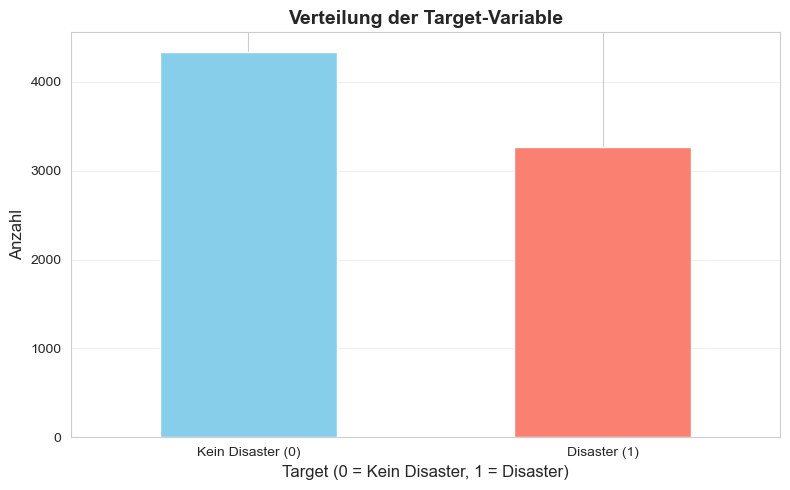

Die Verteilung zeigt, ob die Klassen ausbalanciert sind.


In [25]:
# Visualisierung 1: Target-Verteilung
plt.figure(figsize=(8, 5))
train_df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Verteilung der Target-Variable', fontsize=14, fontweight='bold')
plt.xlabel('Target (0 = Kein Disaster, 1 = Disaster)', fontsize=12)
plt.ylabel('Anzahl', fontsize=12)
plt.xticks([0, 1], ['Kein Disaster (0)', 'Disaster (1)'], rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Die Verteilung zeigt, ob die Klassen ausbalanciert sind.")


In [26]:
# Analysiere Textlängen
train_df['text_length'] = train_df['text'].str.len()
train_df['word_count'] = train_df['text'].str.split().str.len()

print("=== TEXT STATISTIKEN ===")
print(f"Durchschnittliche Textlänge: {train_df['text_length'].mean():.2f} Zeichen")
print(f"Median Textlänge: {train_df['text_length'].median():.2f} Zeichen")
print(f"Durchschnittliche Wortanzahl: {train_df['word_count'].mean():.2f} Wörter")
print(f"Median Wortanzahl: {train_df['word_count'].median():.2f} Wörter")


=== TEXT STATISTIKEN ===
Durchschnittliche Textlänge: 101.04 Zeichen
Median Textlänge: 107.00 Zeichen
Durchschnittliche Wortanzahl: 14.90 Wörter
Median Wortanzahl: 15.00 Wörter


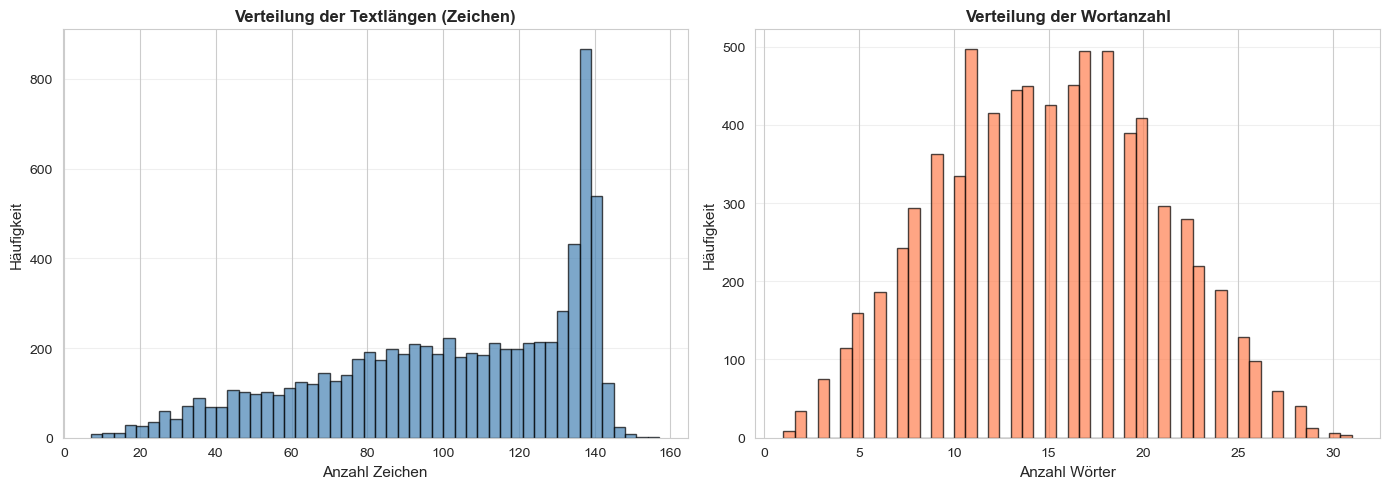

In [27]:
# Visualisierung 2: Textlängen-Verteilung
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramm der Textlängen
axes[0].hist(train_df['text_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Verteilung der Textlängen (Zeichen)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Anzahl Zeichen', fontsize=11)
axes[0].set_ylabel('Häufigkeit', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Histogramm der Wortanzahl
axes[1].hist(train_df['word_count'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_title('Verteilung der Wortanzahl', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Anzahl Wörter', fontsize=11)
axes[1].set_ylabel('Häufigkeit', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


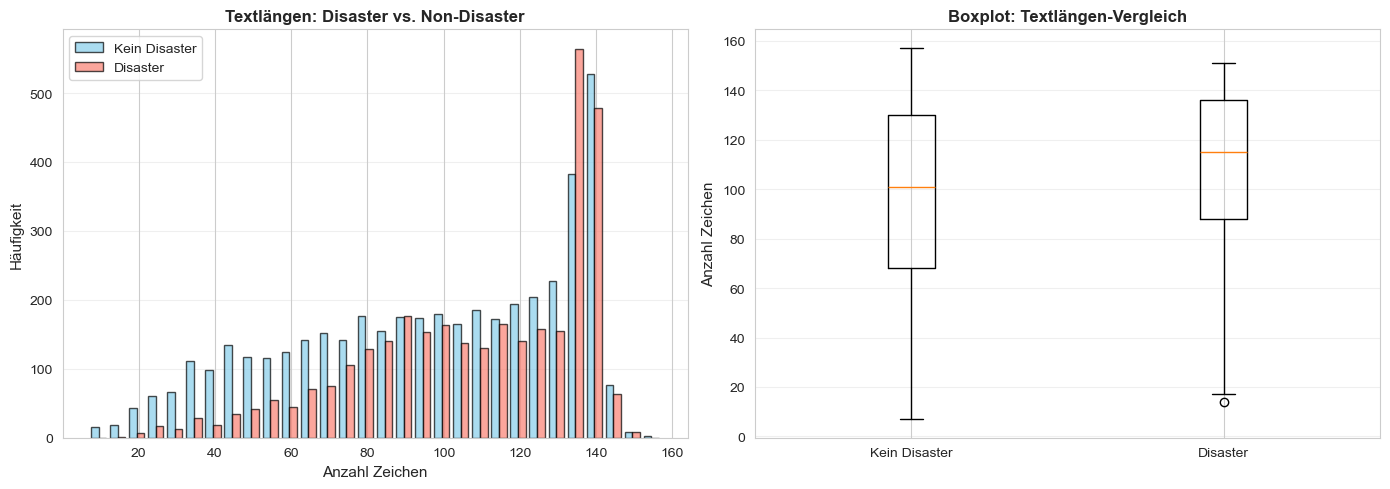


Durchschnittliche Textlänge - Kein Disaster: 95.71
Durchschnittliche Textlänge - Disaster: 108.11


In [28]:
# Vergleich der Textlängen zwischen Disaster und Non-Disaster Tweets
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

disaster_lengths = train_df[train_df['target'] == 1]['text_length']
non_disaster_lengths = train_df[train_df['target'] == 0]['text_length']

axes[0].hist([non_disaster_lengths, disaster_lengths], bins=30, 
             label=['Kein Disaster', 'Disaster'], 
             color=['skyblue', 'salmon'], alpha=0.7, edgecolor='black')
axes[0].set_title('Textlängen: Disaster vs. Non-Disaster', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Anzahl Zeichen', fontsize=11)
axes[0].set_ylabel('Häufigkeit', fontsize=11)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

data_to_plot = [non_disaster_lengths, disaster_lengths]
axes[1].boxplot(data_to_plot, labels=['Kein Disaster', 'Disaster'])
axes[1].set_title('Boxplot: Textlängen-Vergleich', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Anzahl Zeichen', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nDurchschnittliche Textlänge - Kein Disaster: {non_disaster_lengths.mean():.2f}")
print(f"Durchschnittliche Textlänge - Disaster: {disaster_lengths.mean():.2f}")


In [29]:
# Analysiere fehlende Werte
print("=== FEHLENDE WERTE IN TRAIN ===")
missing_train = train_df.isnull().sum()
print(missing_train[missing_train > 0])
print(f"\nProzentual:")
print((missing_train[missing_train > 0] / len(train_df) * 100).round(2))

print("\n=== FEHLENDE WERTE IN TEST ===")
missing_test = test_df.isnull().sum()
print(missing_test[missing_test > 0])
print(f"\nProzentual:")
print((missing_test[missing_test > 0] / len(test_df) * 100).round(2))


=== FEHLENDE WERTE IN TRAIN ===
keyword       61
location    2533
dtype: int64

Prozentual:
keyword      0.80
location    33.27
dtype: float64

=== FEHLENDE WERTE IN TEST ===
keyword       26
location    1105
dtype: int64

Prozentual:
keyword      0.80
location    33.86
dtype: float64


In [30]:
# Erweiterte Text-Bereinigung speziell für Twitter
def advanced_clean_text(text):
    """
    Erweiterte Text-Bereinigung:
    - Hashtags aufsplitten (#EarthquakeAlert → earthquake alert)
    - Emojis in Text umwandeln
    - Kontraktionen expandieren (can't → cannot)
    - Zahlen beibehalten (wichtig für Katastrophen)
    """
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Entferne URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Entferne Twitter-Handles (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Hashtags aufsplitten (#EarthquakeAlert → earthquake alert)
    hashtags = re.findall(r'#\w+', text)
    for hashtag in hashtags:
        words = re.sub(r'([A-Z])', r' \1', hashtag[1:]).strip().lower()
        text = text.replace(hashtag, words)
    
    # Emojis in Text umwandeln (falls verfügbar)
    if EMOJI_AVAILABLE:
        text = emoji.demojize(text, delimiters=(" ", " "))
    
    # Entferne HTML-Entities
    text = re.sub(r'&amp;', '&', text)
    text = re.sub(r'&lt;', '<', text)
    text = re.sub(r'&gt;', '>', text)
    
    # Normalisiere wiederholte Zeichen (z.B. "soooooo" -> "sooo")
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    
    # Expandiere Kontraktionen (can't → cannot) - falls verfügbar
    if EMOJI_AVAILABLE:
        text = contractions.fix(text)
    
    # Konvertiere zu Kleinbuchstaben
    text = text.lower()
    
    # Entferne überflüssige Leerzeichen
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Wende erweiterte Bereinigung an
print("Erweitertes Preprocessing wird angewendet...")
train_df['cleaned_text'] = train_df['text'].apply(advanced_clean_text)
test_df['cleaned_text'] = test_df['text'].apply(advanced_clean_text)

print("Erweitertes Preprocessing abgeschlossen!")
print(f"\nVergleich:")
print(f"Original: {train_df['text'].iloc[0]}")
print(f"Bereinigt: {train_df['cleaned_text'].iloc[0]}")


Erweitertes Preprocessing wird angewendet...
Erweitertes Preprocessing abgeschlossen!

Vergleich:
Original: Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Bereinigt: our deeds are the reason of this earthquake may allah forgive us all


In [31]:
# Vorbereitung der Daten für Tokenisierung
X = train_df['cleaned_text'].values
y = train_df['target'].values
X_test = test_df['cleaned_text'].values

# Teile Trainingsdaten in Train und Validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Trainingsdaten: {len(X_train)}")
print(f"Validationsdaten: {len(X_val)}")
print(f"Testdaten: {len(X_test)}")


Trainingsdaten: 6090
Validationsdaten: 1523
Testdaten: 3263


In [32]:
# Tokenisierung - Konvertiere Texte in Sequenzen von Zahlen
MAX_WORDS = 10000  # Maximale Anzahl verschiedener Wörter im Vokabular
MAX_LEN = 100      # Maximale Tweet-Länge (Padding/Truncation)

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Konvertiere Texte zu Sequenzen
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding: Mache alle Sequenzen gleich lang
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Tokenisierung abgeschlossen!")
print(f"\nX_train_padded Shape: {X_train_padded.shape}")
print(f"X_val_padded Shape: {X_val_padded.shape}")
print(f"X_test_padded Shape: {X_test_padded.shape}")
print(f"\nVokabulargröße: {len(tokenizer.word_index)}")


Tokenisierung abgeschlossen!

X_train_padded Shape: (6090, 100)
X_val_padded Shape: (1523, 100)
X_test_padded Shape: (3263, 100)

Vokabulargröße: 13559


In [33]:
# Lade GloVe Embeddings
# Hinweis: Du musst die GloVe-Datei herunterladen von:
# https://nlp.stanford.edu/projects/glove/
# Wir verwenden glove.6B.100d.txt (100-dimensionale Vektoren)

GLOVE_DIR = 'glove'
GLOVE_FILE = 'glove.6B.100d.txt'
EMBEDDING_DIM = 100

# Erstelle Embedding-Matrix
embeddings_index = {}
glove_path = os.path.join(GLOVE_DIR, GLOVE_FILE)

if os.path.exists(glove_path):
    print(f"Lade GloVe Embeddings von {glove_path}...")
    lines_processed = 0
    lines_skipped = 0
    
    with open(glove_path, encoding='utf-8') as f:
        for line_num, line in enumerate(f, 1):
            if not line.strip():
                lines_skipped += 1
                continue
            
            values = line.rstrip().split()
            
            if len(values) < EMBEDDING_DIM + 1:
                lines_skipped += 1
                continue
            
            try:
                word = values[0]
                coefs = np.asarray(values[1:EMBEDDING_DIM+1], dtype='float32')
                
                if np.isnan(coefs).any() or np.isinf(coefs).any():
                    lines_skipped += 1
                    continue
                
                embeddings_index[word] = coefs
                lines_processed += 1
                
                if lines_processed % 100000 == 0:
                    print(f"  Verarbeitet: {lines_processed} Wörter...")
                    
            except (ValueError, IndexError):
                lines_skipped += 1
                continue
    
    print(f'Gefunden: {len(embeddings_index)} Wort-Vektoren.')
    if lines_skipped > 0:
        print(f'Hinweis: {lines_skipped} Zeilen wurden übersprungen (leer oder fehlerhaft).')
else:
    print(f"WARNUNG: GloVe-Datei nicht gefunden unter {glove_path}")
    print("Bitte lade die Datei von https://nlp.stanford.edu/projects/glove/ herunter")


Lade GloVe Embeddings von glove\glove.6B.100d.txt...
  Verarbeitet: 100000 Wörter...
  Verarbeitet: 200000 Wörter...
  Verarbeitet: 300000 Wörter...
  Verarbeitet: 400000 Wörter...
  Verarbeitet: 500000 Wörter...
  Verarbeitet: 600000 Wörter...
  Verarbeitet: 700000 Wörter...
  Verarbeitet: 800000 Wörter...
  Verarbeitet: 900000 Wörter...
  Verarbeitet: 1000000 Wörter...
  Verarbeitet: 1100000 Wörter...
  Verarbeitet: 1200000 Wörter...
Gefunden: 1287623 Wort-Vektoren.
Hinweis: 3321 Zeilen wurden übersprungen (leer oder fehlerhaft).


In [34]:
# Erstelle Embedding-Matrix für das Modell
word_index = tokenizer.word_index
vocab_size = min(MAX_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

if os.path.exists(glove_path):
    words_found = 0
    for word, i in word_index.items():
        if i < MAX_WORDS:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                words_found += 1
    
    print(f"Von {vocab_size} Wörtern im Vokabular wurden {words_found} in GloVe gefunden.")
    print(f"Abdeckung: {words_found/vocab_size*100:.2f}%")
else:
    print("GloVe nicht verfügbar - verwende zufällige Initialisierung")


Von 10000 Wörtern im Vokabular wurden 8606 in GloVe gefunden.
Abdeckung: 86.06%


In [35]:
# Vorbereitung der Keyword-Features für Multi-Input-Modell
# Fülle fehlende Keywords mit "no_keyword"
train_df['keyword'] = train_df['keyword'].fillna('no_keyword')
test_df['keyword'] = test_df['keyword'].fillna('no_keyword')

# Erstelle separaten Tokenizer für Keywords
keyword_tokenizer = Tokenizer(num_words=500, oov_token="<OOV>")
keyword_tokenizer.fit_on_texts(train_df['keyword'].values)

# Tokenisiere Keywords
train_keywords_seq = keyword_tokenizer.texts_to_sequences(train_df['keyword'].values)
test_keywords_seq = keyword_tokenizer.texts_to_sequences(test_df['keyword'].values)

# Padding für Keywords (kürzer als Text)
MAX_KEYWORD_LEN = 5
train_keywords_padded = pad_sequences(train_keywords_seq, maxlen=MAX_KEYWORD_LEN, padding='post', truncating='post')
test_keywords_padded = pad_sequences(test_keywords_seq, maxlen=MAX_KEYWORD_LEN, padding='post', truncating='post')

# Split für Keywords (gleicher Split wie für Text)
X_train_keywords, X_val_keywords, _, _ = train_test_split(
    train_keywords_padded, train_df['target'].values, 
    test_size=0.2, random_state=42, stratify=train_df['target'].values
)

print(f"Train Keywords Shape: {X_train_keywords.shape}")
print(f"Val Keywords Shape: {X_val_keywords.shape}")
print(f"Test Keywords Shape: {test_keywords_padded.shape}")


Train Keywords Shape: (6090, 5)
Val Keywords Shape: (1523, 5)
Test Keywords Shape: (3263, 5)


In [36]:
# Modell 1: Baseline LSTM (nur Text, GloVe Embeddings)
from tensorflow.keras.models import Sequential

def create_baseline_model():
    model = Sequential()
    if os.path.exists(glove_path):
        model.add(Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], 
                           input_length=MAX_LEN, trainable=True))
    else:
        model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("Modell 1: Baseline LSTM")
model_baseline = create_baseline_model()
model_baseline.summary()


Modell 1: Baseline LSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Modell 2: Multi-Input-Modell (Text + Keywords)
def create_multi_input_model(use_pretrained_embeddings=True):
    text_input = Input(shape=(MAX_LEN,), name='text_input')
    if use_pretrained_embeddings and os.path.exists(glove_path):
        text_embedding = Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], 
                                   input_length=MAX_LEN, trainable=True)(text_input)
    else:
        text_embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN)(text_input)
    text_lstm = Bidirectional(LSTM(64, return_sequences=False))(text_embedding)
    text_dropout = Dropout(0.5)(text_lstm)
    keyword_input = Input(shape=(MAX_KEYWORD_LEN,), name='keyword_input')
    keyword_embedding = Embedding(500, 32, input_length=MAX_KEYWORD_LEN)(keyword_input)
    keyword_pooled = GlobalMaxPooling1D()(keyword_embedding)
    keyword_dropout = Dropout(0.3)(keyword_pooled)
    concatenated = Concatenate()([text_dropout, keyword_dropout])
    dense1 = Dense(64, activation='relu')(concatenated)
    dropout1 = Dropout(0.5)(dense1)
    output = Dense(1, activation='sigmoid')(dropout1)
    model = Model(inputs=[text_input, keyword_input], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("\nModell 2: Multi-Input (Text + Keywords)")
model_multi_input = create_multi_input_model(use_pretrained_embeddings=True)
model_multi_input.summary()



Modell 2: Multi-Input (Text + Keywords)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keyword_input       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 100, 100)  │  1,000,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 5, 32)     │     16,000 │ keyword_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 128)       │     84,480 │ embedding_3[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ embedding_4[0][0] │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 32)        │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 160)       │          0 │ dropout_5[0][0],  │
│ (Concatenate)       │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     10,304 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,110,849 (4.24 MB)

 Trainable params: 1,110,849 (4.24 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Modell 3: Verbessertes LSTM (größere Architektur, nur Text)
def create_improved_lstm_model():
    model = Sequential()
    if os.path.exists(glove_path):
        model.add(Embedding(vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], 
                           input_length=MAX_LEN, trainable=True))
    else:
        model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

print("\nModell 3: Verbessertes LSTM (größere Architektur)")
model_improved = create_improved_lstm_model()
model_improved.summary()



Modell 3: Verbessertes LSTM (größere Architektur)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Class Weights berechnen
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class Weights: {class_weight_dict}")

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001, verbose=1)


Class Weights: {0: np.float64(0.8767636049524906), 1: np.float64(1.1635460450897974)}


In [40]:
# Training Modell 1: Baseline LSTM
print("=" * 60)
print("TRAINING: Modell 1 - Baseline LSTM")
print("=" * 60)
history_baseline = model_baseline.fit(
    X_train_padded, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_padded, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


TRAINING: Modell 1 - Baseline LSTM
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - accuracy: 0.7420 - loss: 0.5361 - val_accuracy: 0.8096 - val_loss: 0.4422 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8268 - loss: 0.4277 - val_accuracy: 0.8129 - val_loss: 0.4198 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8540 - loss: 0.3637 - val_accuracy: 0.7945 - val_loss: 0.4625 - learning_rate: 0.0010
Epoch 4/10
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8730 - loss: 0.3137
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.8787 - loss: 0.3072 - val_accuracy: 0.8096 - val_loss: 0.4408 - learning_rate: 0.0010
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9148 - loss: 0.2382 - val_accuracy: 0.7991 - val_loss: 0.4931 - learning_rate: 2.0000e-04
Epoch 5: early stopping
Restoring model we

In [41]:
# Training Modell 2: Multi-Input (Text + Keywords)
print("=" * 60)
print("TRAINING: Modell 2 - Multi-Input (Text + Keywords)")
print("=" * 60)
history_multi = model_multi_input.fit(
    [X_train_padded, X_train_keywords], y_train,
    batch_size=32,
    epochs=10,
    validation_data=([X_val_padded, X_val_keywords], y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


TRAINING: Modell 2 - Multi-Input (Text + Keywords)
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.7402 - loss: 0.5295 - val_accuracy: 0.8135 - val_loss: 0.4383 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8276 - loss: 0.4198 - val_accuracy: 0.8116 - val_loss: 0.4173 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.8571 - loss: 0.3655 - val_accuracy: 0.7971 - val_loss: 0.4410 - learning_rate: 0.0010
Epoch 4/10
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8830 - loss: 0.3123
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8823 - loss: 0.3099 - val_accuracy: 0.8221 - val_loss: 0.4339 - learning_rate: 0.0010
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9138 - loss: 0.2440 - val_accuracy: 0.8135 - val_loss: 0.4937 - learning_rate: 2.0000e-04
Epoch 5: early stopping
Re

In [42]:
# Training Modell 3: Verbessertes LSTM
print("=" * 60)
print("TRAINING: Modell 3 - Verbessertes LSTM")
print("=" * 60)
history_improved = model_improved.fit(
    X_train_padded, y_train,
    batch_size=32,
    epochs=10,
    validation_data=(X_val_padded, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


TRAINING: Modell 3 - Verbessertes LSTM
Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - accuracy: 0.7476 - loss: 0.5359 - val_accuracy: 0.8050 - val_loss: 0.4416 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.8243 - loss: 0.4332
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 126ms/step - accuracy: 0.8281 - loss: 0.4222 - val_accuracy: 0.8109 - val_loss: 0.4334 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.8686 - loss: 0.3457 - val_accuracy: 0.8148 - val_loss: 0.4464 - learning_rate: 2.0000e-04
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [43]:
# Evaluation aller 3 Modelle
print("=" * 60)
print("EVALUATION ALLER MODELLE")
print("=" * 60)

# Modell 1: Baseline
y_pred_proba_baseline = model_baseline.predict(X_val_padded).flatten()
y_pred_baseline = (y_pred_proba_baseline > 0.5).astype(int)
f1_baseline = f1_score(y_val, y_pred_baseline)
print(f"\nModell 1 - Baseline LSTM:")
print(f"F1-Score: {f1_baseline:.4f}")
print(f"Accuracy: {np.mean(y_val == y_pred_baseline):.4f}")

# Modell 2: Multi-Input
y_pred_proba_multi = model_multi_input.predict([X_val_padded, X_val_keywords]).flatten()
y_pred_multi = (y_pred_proba_multi > 0.5).astype(int)
f1_multi = f1_score(y_val, y_pred_multi)
print(f"\nModell 2 - Multi-Input (Text + Keywords):")
print(f"F1-Score: {f1_multi:.4f}")
print(f"Accuracy: {np.mean(y_val == y_pred_multi):.4f}")

# Modell 3: Verbessertes LSTM
y_pred_proba_improved = model_improved.predict(X_val_padded).flatten()
y_pred_improved = (y_pred_proba_improved > 0.5).astype(int)
f1_improved = f1_score(y_val, y_pred_improved)
print(f"\nModell 3 - Verbessertes LSTM:")
print(f"F1-Score: {f1_improved:.4f}")
print(f"Accuracy: {np.mean(y_val == y_pred_improved):.4f}")


EVALUATION ALLER MODELLE
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

Modell 1 - Baseline LSTM:
F1-Score: 0.7761
Accuracy: 0.8129
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Modell 2 - Multi-Input (Text + Keywords):
F1-Score: 0.7653
Accuracy: 0.8116
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step

Modell 3 - Verbessertes LSTM:
F1-Score: 0.7703
Accuracy: 0.8050


In [44]:
# Threshold-Optimierung für alle Modelle
print("=" * 60)
print("THRESHOLD-OPTIMIERUNG FÜR ALLE MODELLE")
print("=" * 60)

# Modell 1
precision_baseline, recall_baseline, thresholds_baseline = precision_recall_curve(y_val, y_pred_proba_baseline)
f1_scores_baseline = 2 * (precision_baseline * recall_baseline) / (precision_baseline + recall_baseline + 1e-10)
optimal_idx_baseline = np.argmax(f1_scores_baseline)
optimal_threshold_baseline = thresholds_baseline[optimal_idx_baseline]
optimal_f1_baseline = f1_scores_baseline[optimal_idx_baseline]

# Modell 2
precision_multi, recall_multi, thresholds_multi = precision_recall_curve(y_val, y_pred_proba_multi)
f1_scores_multi = 2 * (precision_multi * recall_multi) / (precision_multi + recall_multi + 1e-10)
optimal_idx_multi = np.argmax(f1_scores_multi)
optimal_threshold_multi = thresholds_multi[optimal_idx_multi]
optimal_f1_multi = f1_scores_multi[optimal_idx_multi]

# Modell 3
precision_improved, recall_improved, thresholds_improved = precision_recall_curve(y_val, y_pred_proba_improved)
f1_scores_improved = 2 * (precision_improved * recall_improved) / (precision_improved + recall_improved + 1e-10)
optimal_idx_improved = np.argmax(f1_scores_improved)
optimal_threshold_improved = thresholds_improved[optimal_idx_improved]
optimal_f1_improved = f1_scores_improved[optimal_idx_improved]

# Teste mit optimalen Thresholds
y_pred_optimal_baseline = (y_pred_proba_baseline > optimal_threshold_baseline).astype(int)
f1_optimal_baseline = f1_score(y_val, y_pred_optimal_baseline)

y_pred_optimal_multi = (y_pred_proba_multi > optimal_threshold_multi).astype(int)
f1_optimal_multi = f1_score(y_val, y_pred_optimal_multi)

y_pred_optimal_improved = (y_pred_proba_improved > optimal_threshold_improved).astype(int)
f1_optimal_improved = f1_score(y_val, y_pred_optimal_improved)

print(f"\nModell 1 - Baseline:")
print(f"  Standard Threshold (0.5): F1 = {f1_baseline:.4f}")
print(f"  Optimal Threshold ({optimal_threshold_baseline:.4f}): F1 = {f1_optimal_baseline:.4f}")

print(f"\nModell 2 - Multi-Input:")
print(f"  Standard Threshold (0.5): F1 = {f1_multi:.4f}")
print(f"  Optimal Threshold ({optimal_threshold_multi:.4f}): F1 = {f1_optimal_multi:.4f}")

print(f"\nModell 3 - Verbessertes LSTM:")
print(f"  Standard Threshold (0.5): F1 = {f1_improved:.4f}")
print(f"  Optimal Threshold ({optimal_threshold_improved:.4f}): F1 = {f1_optimal_improved:.4f}")


THRESHOLD-OPTIMIERUNG FÜR ALLE MODELLE

Modell 1 - Baseline:
  Standard Threshold (0.5): F1 = 0.7761
  Optimal Threshold (0.5258): F1 = 0.7807

Modell 2 - Multi-Input:
  Standard Threshold (0.5): F1 = 0.7653
  Optimal Threshold (0.4024): F1 = 0.7820

Modell 3 - Verbessertes LSTM:
  Standard Threshold (0.5): F1 = 0.7703
  Optimal Threshold (0.4544): F1 = 0.7711


VERGLEICH ALLER MODELLE

F1-Scores im Vergleich:
Multi-Input (Optimal Threshold)         : 0.7820
Baseline LSTM (Optimal Threshold)       : 0.7807
Baseline LSTM (Standard)                : 0.7761
Verbessertes LSTM (Optimal Threshold)   : 0.7711
Verbessertes LSTM (Standard)            : 0.7703
Multi-Input (Standard)                  : 0.7653

🏆 Bestes Modell: Multi-Input (Optimal Threshold) mit F1-Score: 0.7820


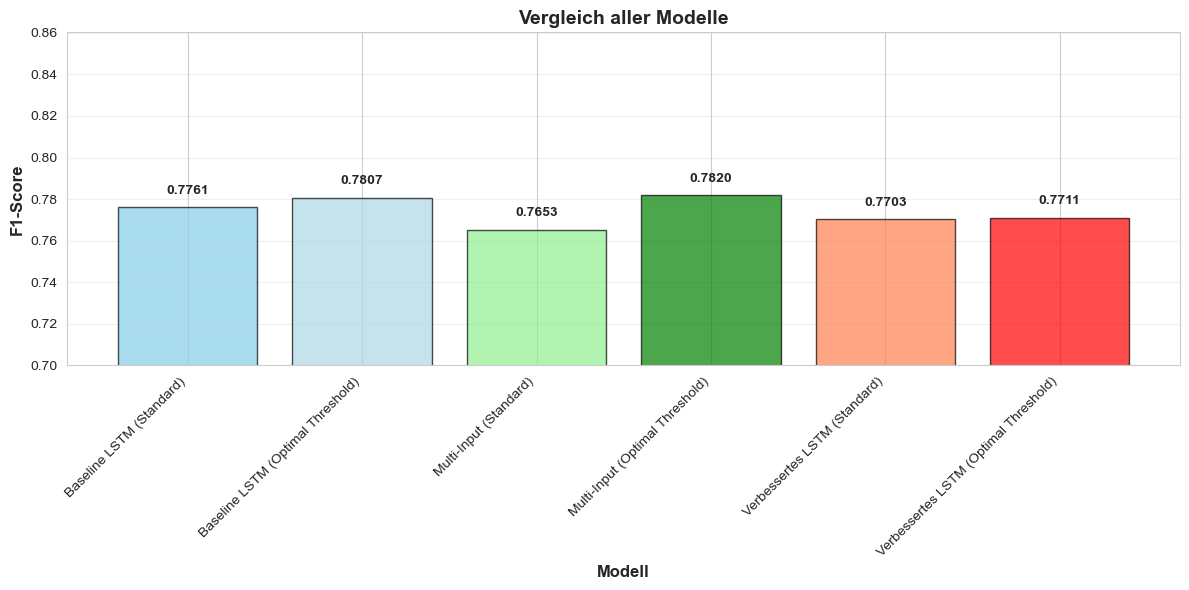

In [45]:
# Vergleich aller Modelle
print("=" * 60)
print("VERGLEICH ALLER MODELLE")
print("=" * 60)

results = {
    'Baseline LSTM (Standard)': f1_baseline,
    'Baseline LSTM (Optimal Threshold)': f1_optimal_baseline,
    'Multi-Input (Standard)': f1_multi,
    'Multi-Input (Optimal Threshold)': f1_optimal_multi,
    'Verbessertes LSTM (Standard)': f1_improved,
    'Verbessertes LSTM (Optimal Threshold)': f1_optimal_improved
}

print("\nF1-Scores im Vergleich:")
for model_name, f1 in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{model_name:40s}: {f1:.4f}")

best_model_name = max(results.items(), key=lambda x: x[1])[0]
best_f1 = max(results.values())
print(f"\n🏆 Bestes Modell: {best_model_name} mit F1-Score: {best_f1:.4f}")

# Visualisierung
plt.figure(figsize=(12, 6))
models = list(results.keys())
f1_scores = list(results.values())
colors = ['skyblue', 'lightblue', 'lightgreen', 'green', 'coral', 'red']
bars = plt.bar(range(len(models)), f1_scores, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('Modell', fontsize=12, fontweight='bold')
plt.ylabel('F1-Score', fontsize=12, fontweight='bold')
plt.title('Vergleich aller Modelle', fontsize=14, fontweight='bold')
plt.xticks(range(len(models)), models, rotation=45, ha='right')
plt.ylim([0.7, max(f1_scores) * 1.1])
plt.grid(axis='y', alpha=0.3)
for i, (bar, score) in enumerate(zip(bars, f1_scores)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()


In [46]:
# Finale Submission mit dem besten Modell
print("=" * 60)
print("ERSTELLE FINALE SUBMISSION")
print("=" * 60)

if 'Multi-Input' in best_model_name:
    test_pred_proba = model_multi_input.predict([X_test_padded, test_keywords_padded]).flatten()
    if 'Optimal' in best_model_name:
        optimal_threshold = optimal_threshold_multi
    else:
        optimal_threshold = 0.5
    test_pred_final = (test_pred_proba > optimal_threshold).astype(int)
    print(f"Verwende: Multi-Input-Modell (Threshold: {optimal_threshold:.4f})")
elif 'Verbessertes LSTM' in best_model_name:
    test_pred_proba = model_improved.predict(X_test_padded).flatten()
    if 'Optimal' in best_model_name:
        optimal_threshold = optimal_threshold_improved
    else:
        optimal_threshold = 0.5
    test_pred_final = (test_pred_proba > optimal_threshold).astype(int)
    print(f"Verwende: Verbessertes LSTM (Threshold: {optimal_threshold:.4f})")
else:
    test_pred_proba = model_baseline.predict(X_test_padded).flatten()
    if 'Optimal' in best_model_name:
        optimal_threshold = optimal_threshold_baseline
    else:
        optimal_threshold = 0.5
    test_pred_final = (test_pred_proba > optimal_threshold).astype(int)
    print(f"Verwende: Baseline LSTM (Threshold: {optimal_threshold:.4f})")

submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_pred_final
})

submission.to_csv('submission.csv', index=False)
print("\nSubmission-Datei erstellt: submission.csv")
print(f"Vorhersagen-Verteilung:")
print(submission['target'].value_counts())
print(f"\nErwarteter F1-Score auf Kaggle: ~{best_f1:.4f}")


ERSTELLE FINALE SUBMISSION
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Verwende: Multi-Input-Modell (Threshold: 0.4024)

Submission-Datei erstellt: submission.csv
Vorhersagen-Verteilung:
target
0    1900
1    1363
Name: count, dtype: int64

Erwarteter F1-Score auf Kaggle: ~0.7820


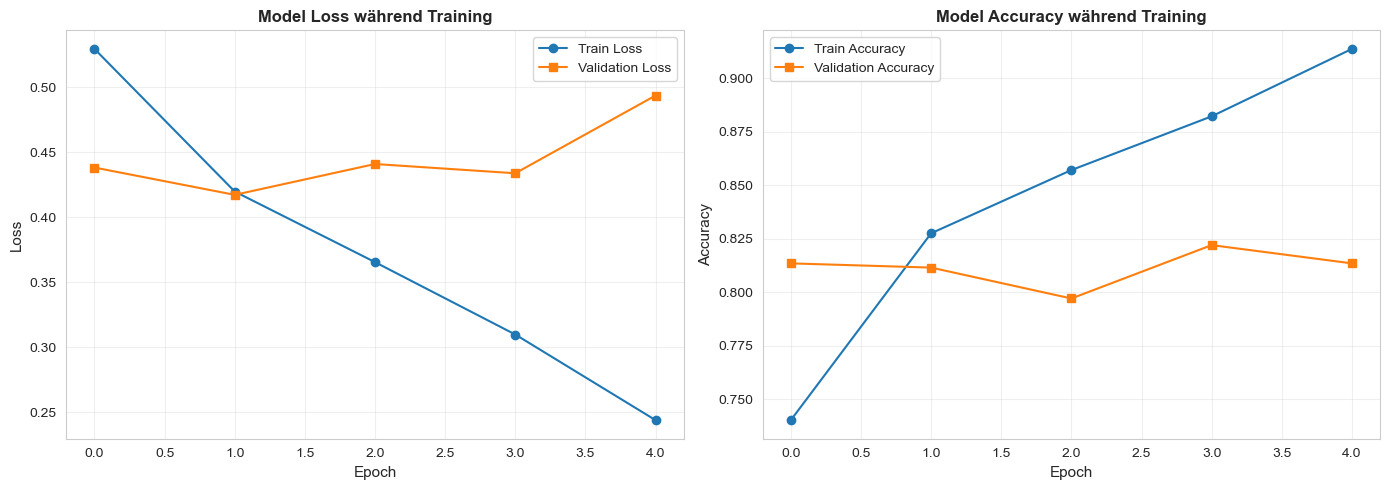

In [47]:
# Visualisiere Training History
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss Plot
axes[0].plot(history_multi.history['loss'], label='Train Loss', marker='o')
axes[0].plot(history_multi.history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_title('Model Loss während Training', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy Plot
axes[1].plot(history_multi.history['accuracy'], label='Train Accuracy', marker='o')
axes[1].plot(history_multi.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[1].set_title('Model Accuracy während Training', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [48]:
# Evaluation auf Validation Set
y_pred_proba_multi = model_multi_input.predict([X_val_padded, X_val_keywords]).flatten()
y_pred_multi = (y_pred_proba_multi > 0.5).astype(int)
f1_multi = f1_score(y_val, y_pred_multi)

print(f"\n=== ERGEBNIS MULTI-INPUT-MODELL ===")
print(f"F1-Score: {f1_multi:.4f}")
print(f"Accuracy: {np.mean(y_val == y_pred_multi):.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_multi, target_names=['Kein Disaster', 'Disaster']))


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

=== ERGEBNIS MULTI-INPUT-MODELL ===
F1-Score: 0.7653
Accuracy: 0.8116

Classification Report:
               precision    recall  f1-score   support

Kein Disaster       0.81      0.88      0.84       869
     Disaster       0.82      0.72      0.77       654

     accuracy                           0.81      1523
    macro avg       0.81      0.80      0.80      1523
 weighted avg       0.81      0.81      0.81      1523



THRESHOLD-OPTIMIERUNG FÜR MULTI-INPUT-MODELL
Optimaler Threshold: 0.4024 (statt 0.5)
F1-Score mit optimalem Threshold: 0.7829


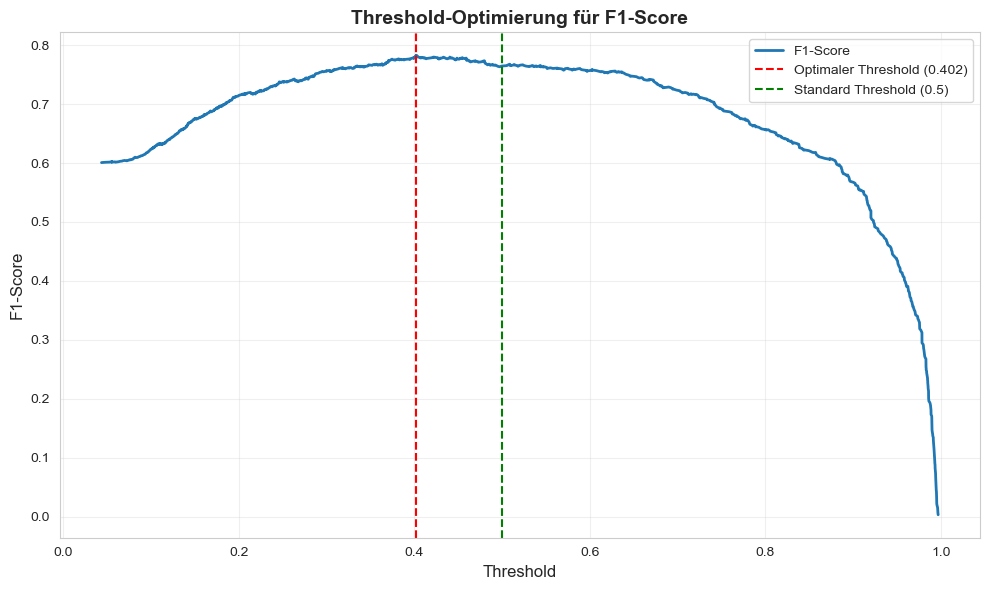


F1-Score mit optimalem Threshold: 0.7820

Classification Report:
               precision    recall  f1-score   support

Kein Disaster       0.84      0.82      0.83       869
     Disaster       0.77      0.80      0.78       654

     accuracy                           0.81      1523
    macro avg       0.80      0.81      0.81      1523
 weighted avg       0.81      0.81      0.81      1523



In [49]:
# Threshold-Optimierung für maximale F1-Score
print("=" * 60)
print("THRESHOLD-OPTIMIERUNG FÜR MULTI-INPUT-MODELL")
print("=" * 60)

precision_multi, recall_multi, thresholds_multi = precision_recall_curve(y_val, y_pred_proba_multi)
f1_scores_thresh_multi = 2 * (precision_multi * recall_multi) / (precision_multi + recall_multi + 1e-10)
optimal_idx_multi = np.argmax(f1_scores_thresh_multi)
optimal_threshold_multi = thresholds_multi[optimal_idx_multi]
optimal_f1_multi = f1_scores_thresh_multi[optimal_idx_multi]

print(f"Optimaler Threshold: {optimal_threshold_multi:.4f} (statt 0.5)")
print(f"F1-Score mit optimalem Threshold: {optimal_f1_multi:.4f}")

# Visualisierung
plt.figure(figsize=(10, 6))
plt.plot(thresholds_multi, f1_scores_thresh_multi[:-1], label='F1-Score', linewidth=2)
plt.axvline(x=optimal_threshold_multi, color='r', linestyle='--', label=f'Optimaler Threshold ({optimal_threshold_multi:.3f})')
plt.axvline(x=0.5, color='g', linestyle='--', label='Standard Threshold (0.5)')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1-Score', fontsize=12)
plt.title('Threshold-Optimierung für F1-Score', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Teste mit optimalem Threshold
y_pred_optimal_multi = (y_pred_proba_multi > optimal_threshold_multi).astype(int)
f1_optimal_multi = f1_score(y_val, y_pred_optimal_multi)

print(f"\nF1-Score mit optimalem Threshold: {f1_optimal_multi:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_optimal_multi, target_names=['Kein Disaster', 'Disaster']))


In [50]:
# Erstelle finale Submission mit dem besten Modell (Multi-Input + Optimal Threshold)
print("=" * 60)
print("ERSTELLE FINALE SUBMISSION")
print("=" * 60)

# Vorhersagen auf Test-Daten
test_pred_proba = model_multi_input.predict([X_test_padded, test_keywords_padded]).flatten()
test_pred_final = (test_pred_proba > optimal_threshold_multi).astype(int)

# Erstelle Submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_pred_final
})

# Speichere Submission
submission.to_csv('submission.csv', index=False)
print("\nSubmission-Datei erstellt: submission.csv")
print(f"\nVorhersagen-Verteilung:")
print(submission['target'].value_counts())
print(f"\nErwarteter F1-Score auf Kaggle: ~{f1_optimal_multi:.4f}")


ERSTELLE FINALE SUBMISSION
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step

Submission-Datei erstellt: submission.csv

Vorhersagen-Verteilung:
target
0    1900
1    1363
Name: count, dtype: int64

Erwarteter F1-Score auf Kaggle: ~0.7820
